In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd_data = pd.read_csv(r"D:\chang\weather\weather_prediction_dataset.csv")
pd_data = pd_data.drop(columns=['DATE','MONTH'])

# 전처리
normalization_df = (pd_data - pd_data.mean())/pd_data.std()

pd_data_Y = pd.DataFrame()
pd_data_X = normalization_df
for i in pd_data.columns:
    if 'temp_mean' in i:
        pd_data_Y[i] = pd_data[i]
        pd_data_X[i] = pd_data[i]

In [3]:
temperature = np.zeros((len(pd_data),len(pd_data_Y.columns)))
raw_data = np.zeros((len(pd_data), len(pd_data.columns)))
for i in range(len(pd_data)):
    temperature[i] = pd_data_Y.iloc[i].values
    raw_data[i,:] = pd_data_X.iloc[i].values

In [4]:
sampling_rate = 1
sequence_length = 20
delay = 1
batch_size = 512

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=2923)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=2923-sequence_length,
    end_index=3289-sequence_length)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=1,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=3289-sequence_length)

In [5]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
gru = layers.GRU(163,recurrent_dropout=0.2, return_sequences=True)(inputs)
gru2 = layers.GRU(163)(gru)
att = layers.Attention()([gru,gru2])
x = layers.Dropout(0.5)(gru2)
outputs = layers.Dense(18)(x)
model = keras.Model(inputs, outputs)
print(model.summary())

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 163)]         0         
_________________________________________________________________
gru (GRU)                    (None, 20, 163)           160392    
_________________________________________________________________
gru_1 (GRU)                  (None, 163)               160392    
_________________________________________________________________
dropout (Dropout)            (None, 163)               0         
_________________________________________________________________
dense (Dense)                (None, 18)                2952      
Total params: 323,736
Trainable params: 323,736
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5000,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
model.evaluate(test_dataset)

Epoch 1/5000
6/6 [==============================] - 9s 378ms/step - loss: 136.9225 - mae: 9.7635 - val_loss: 97.9514 - val_mae: 8.1347
Epoch 2/5000
6/6 [==============================] - 1s 192ms/step - loss: 94.0122 - mae: 7.8826 - val_loss: 77.9849 - val_mae: 7.0984
Epoch 3/5000
6/6 [==============================] - 1s 188ms/step - loss: 77.3191 - mae: 7.0160 - val_loss: 65.2106 - val_mae: 6.3843
Epoch 4/5000
6/6 [==============================] - 1s 172ms/step - loss: 65.7185 - mae: 6.3850 - val_loss: 54.8758 - val_mae: 5.7480
Epoch 5/5000
6/6 [==============================] - 1s 179ms/step - loss: 56.7802 - mae: 5.8888 - val_loss: 46.8763 - val_mae: 5.2557
Epoch 6/5000
6/6 [==============================] - 1s 196ms/step - loss: 48.9296 - mae: 5.3988 - val_loss: 40.1526 - val_mae: 4.8209
Epoch 7/5000
6/6 [==============================] - 1s 197ms/step - loss: 42.7183 - mae: 5.0312 - val_loss: 33.9536 - val_mae: 4.3772
Epoch 8/5000
6/6 [==============================] - 1s 200ms/

[0.6002287268638611, 0.5660187005996704]

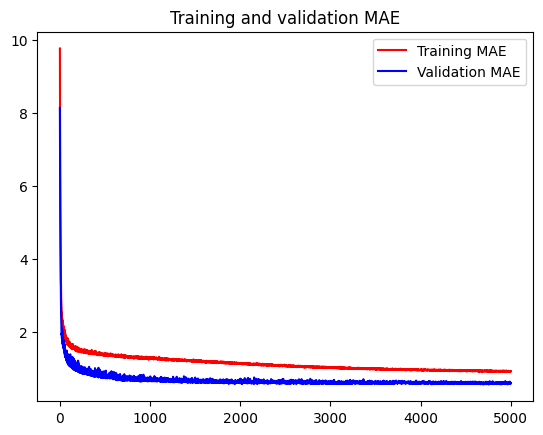

In [7]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [8]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 167ms/step - loss: 0.6002 - mae: 0.5660


[0.6002287268638611, 0.5660187005996704]

In [9]:
prediceted = model.predict(test_dataset)

In [10]:
len(prediceted)

365

In [11]:
prediceted

array([[ -0.10046864,   3.4091492 ,   3.1093326 , ...,  -9.798176  ,
          2.0420063 ,   4.0746307 ],
       [  1.0558672 ,   6.5251303 ,   3.1059394 , ...,  -8.10059   ,
          3.1645284 ,   4.3707266 ],
       [  1.3710771 ,   7.452122  ,   2.0050364 , ...,  -7.1154504 ,
          3.440917  ,   2.4843931 ],
       ...,
       [  4.5563617 ,   3.6300306 ,   6.9270267 , ..., -11.72386   ,
          2.2599492 ,   6.15737   ],
       [  1.2923822 ,   2.3077812 ,   3.7407446 , ..., -15.317072  ,
          0.62577295,   3.86724   ],
       [ -0.05707836,   0.25746155,   1.140924  , ..., -14.568823  ,
          1.0710449 ,   1.9189363 ]], dtype=float32)